---
title: Quantifying Three Years of Reading
tags: Bayesian Statistics, PyMC3, Books, Personal
---

Since December 2014, I have [tracked](https://cdn.knightlab.com/libs/timeline3/latest/embed/index.html?source=1wNbJv1Zf4Oichj3-dEQXE_lXVCwuYQjaoyU1gGQQqk4&font=Default&lang=en&start_at_end=true&initial_zoom=2&height=650) the books I read in a Google spreadsheet.  It recently occurred to me to use this data to quantify how my reading habits have changed over time.  This post will use [PyMC3](https://github.com/pymc-devs/pymc3) to model my reading habits.

In [2]:
%matplotlib inline

In [3]:
from itertools import product

In [4]:
from matplotlib import dates as mdates
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns
from theano import shared, tensor as tt

In [5]:
sns.set()

In [6]:
SEED = 27432 # from random.org, for reproductibility

First we load the data from the Google Spreadsheet.  Conveniently, [`pandas`](https://github.com/pymc-devs/pymc3/pull/2766) can load CSVs from a web link.

In [17]:
raw_df = (pd.read_csv('Reading Log Timeine - od1.csv',
                usecols=[
                    'Year', 'Month', 'Day',
                    'End Year', 'End Month', 'End Day',
                    'Headline', 'Text'
                ]
            )
            .dropna(axis=1, how='all')
            .dropna(axis=0))
raw_df.head()

,Year,Month,Day,End Year,End Month,End Day,Headline,Text
0,2014,12,13,2014.0,12.0,23.0,The Bloody Chamber,"Angela Carter, 126 pages"
1,2014,12,23,2015.0,1.0,4.0,The Last Place on Earth,"Roland Huntford, 564 pages"
2,2015,1,24,2015.0,2.0,13.0,Empire Falls,"Richard Russo, 483 pages"
3,2015,2,14,2015.0,2.0,20.0,Wonder Boys,"Michael Chabon, 368 pages"
4,2015,2,25,2015.0,3.0,4.0,"Red State, Blue State, Rich State, Poor State:...","Andrew Gelman, 196 pages"


In [18]:
raw_df.tail()

,Year,Month,Day,End Year,End Month,End Day,Headline,Text
61,2017,10,27,2017.0,12.0,7.0,The History of Statistics: The Measurement of ...,"Stephen M. Stigler, 361 pages"
62,2017,12,8,2017.0,12.0,21.0,An Arsonist's Guide to Writers' Homes in New E...,"Brock Clarke, 303 pages"
63,2017,12,22,2018.0,1.0,1.0,Watership Down,"Richard Adams, 481 pages"
64,2018,1,2,2018.0,1.0,7.0,The Ladies of Grace Adieu,"Susanna Clarke, 235 pages"
65,2018,1,7,2018.0,1.0,9.0,Remembering South Cape May: The Jersey Shore T...,"Joseph G. Burcher with Robert Kenselaar, 110 p..."


The spreadhseet is formatted for use with [Knight Lab's](https://knightlab.northwestern.edu/) excellent [TimelineJS](https://timeline.knightlab.com/) package.  We transform the data to a more useful format for our purposes.

In [19]:
df = pd.DataFrame({
    'start_date': raw_df.apply(
        lambda s: pd.datetime(
            s['Year'],
            s['Month'],
            s['Day']
        ),
        axis=1
    ),
    'end_date': raw_df.apply(
        lambda s: pd.datetime(
            int(s['End Year']),
            int(s['End Month']),
            int(s['End Day'])
        ),
        axis=1
    ),
    'title': raw_df['Headline'],
    'author': (raw_df['Text']
                     .str.extract('(.*),.*', expand=True)
                     .iloc[:, 0]),
    'pages': (raw_df['Text']
                    .str.extract(r'.*, (\d+) pages', expand=False)
                    .astype(np.int64))
})

df['days'] = (df['end_date']
                .sub(df['start_date'])
                .dt.days)

df = df[[
    'author', 'title',
    'start_date', 'end_date', 'days',
    'pages'
]]

Each row of the dataframe corresponds to a book I have read, and the columns are

* `author`, the book's author,
* `title`, the book's title,
* `start_date`, the date I started reading the book,
* `end_date`, the date I finished reading the book,
* `days`, then number of days it took me to read the book, and
* `pages`, the number of pages in the book.

In [20]:
df.head()

,author,title,start_date,end_date,days,pages
0,Angela Carter,The Bloody Chamber,2014-12-13,2014-12-23,10,126
1,Roland Huntford,The Last Place on Earth,2014-12-23,2015-01-04,12,564
2,Richard Russo,Empire Falls,2015-01-24,2015-02-13,20,483
3,Michael Chabon,Wonder Boys,2015-02-14,2015-02-20,6,368
4,Andrew Gelman,"Red State, Blue State, Rich State, Poor State:...",2015-02-25,2015-03-04,7,196


In [21]:
df.tail()

,author,title,start_date,end_date,days,pages
61,Stephen M. Stigler,The History of Statistics: The Measurement of ...,2017-10-27,2017-12-07,41,361
62,Brock Clarke,An Arsonist's Guide to Writers' Homes in New E...,2017-12-08,2017-12-21,13,303
63,Richard Adams,Watership Down,2017-12-22,2018-01-01,10,481
64,Susanna Clarke,The Ladies of Grace Adieu,2018-01-02,2018-01-07,5,235
65,Joseph G. Burcher with Robert Kenselaar,Remembering South Cape May: The Jersey Shore T...,2018-01-07,2018-01-09,2,110


## Modeling

We will model the number of days it takes me to read a book using count regression models based on the number of pages.  It would also be reasonable to analyze this data using [survival models](https://en.wikipedia.org/wiki/Survival_analysis).

### Negative binomial regression

While [Poisson regression](https://en.wikipedia.org/wiki/Poisson_regression) is perhaps the simplest count regression model, we see that these data are fairly [overdispersed](https://en.wikipedia.org/wiki/Index_of_dispersion)

In [22]:
df['days'].var() / df['days'].mean()

14.568259109311741

so [negative binomial regression](http://www.karlin.mff.cuni.cz/~pesta/NMFM404/NB.html) is more appropriate.  We further verify that negative binomial regression is appropriate by plotting the logarithm of the number of pages versus the logarithm of the number of days it took me to read the book, since the logarithm is the [link function](https://en.wikipedia.org/wiki/Generalized_linear_model#Link_function) for the negative binomial GLM.

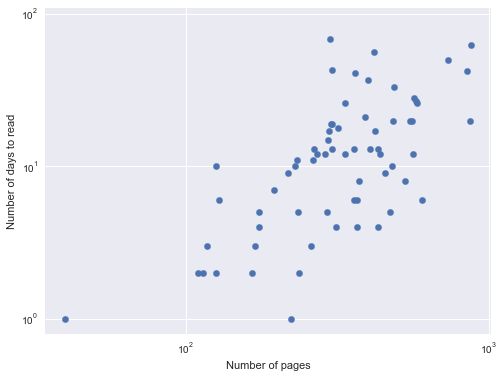

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

df.plot(
    'pages', 'days',
    s=40, kind='scatter',
    ax=ax
);

ax.set_xscale('log');
ax.set_xlabel("Number of pages");

ax.set_yscale('log');
ax.set_ylim(top=1.1e2);
ax.set_ylabel("Number of days to read");

This approximately linear relationship confirms the suitability of a negative binomial model.

Now we introduce some notation.  Let $y_i$ be the number of days it took me to read the $i$-th book and $x^{\textrm{pages}}_i$ be the (standardized) logarithm of the number of pages in the $i$-th book.  Our first model is

$$
\begin{align*}
    \beta^0, \beta^{\textrm{pages}}
        & \sim N(0, 5^2) \\
    \theta_i
        & \sim \beta^0 + \beta^{\textrm{pages}} \cdot x^{\textrm{pages}}_i \\
    \mu_i
        & = \exp({\theta_i}) \\
    \alpha
        & \sim \operatorname{Lognormal}(0, 5^2) \\
    y_i - 1
        & \sim \operatorname{NegativeBinomial}(\mu_i, \alpha).
\end{align*}
$$

This model is expressed in PyMC3 below.

In [24]:
days = df['days'].values

pages = df['pages'].values
pages_ = shared(pages)

In [25]:
with pm.Model() as nb_model:
    β0 = pm.Normal('β0', 0., 5.)
    β_pages = pm.Normal('β_pages', 0., 5.)
    
    log_pages = tt.log(pages_)
    log_pages_std = (log_pages - log_pages.mean()) / log_pages.std()

    θ = β0 + β_pages * log_pages_std
    μ = tt.exp(θ)
    
    α = pm.Lognormal('α', 0., 5.)
    
    days_obs = pm.NegativeBinomial('days_obs', μ, α, observed=days - 1)

We now sample from the model's posterior distribution.

In [26]:
NJOBS = 3
SAMPLE_KWARGS = {
    'njobs': NJOBS,
    'random_seed': [SEED + i for i in range(NJOBS)]
}

In [27]:
with nb_model:
    nb_trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


We check a few convergence diagnostics.  The BFMI and energy distributions for our samples show no cause for concern.

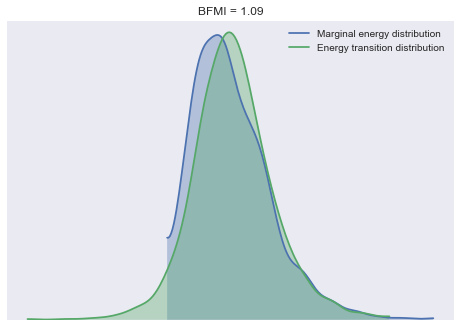

In [29]:
ax = pm.energyplot(nb_trace)

bfmi = pm.bfmi(nb_trace)
ax.set_title(f"BFMI = {bfmi:.2f}");

The Gelman-Rubin statistics indicate that the chains have converged.

In [30]:
max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(nb_trace).values())

1.0020294025358027

We use the posterior samples to make predictions so that we can examine residuals.

In [31]:
with nb_model:
    nb_pred_trace = pm.sample_ppc(nb_trace)
    
nb_pred_days = nb_pred_trace['days_obs'].mean(axis=0)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 393.34it/s]


Since the mean and variance of the negative binomial distribution are [related](https://en.wikipedia.org/wiki/Negative_binomial_distribution), we use standardized residuals to untangle this relationship.

In [32]:
nb_std_resid = (days - nb_pred_days) / nb_pred_trace['days_obs'].std(axis=0)

We visualize these standardized residuals below.

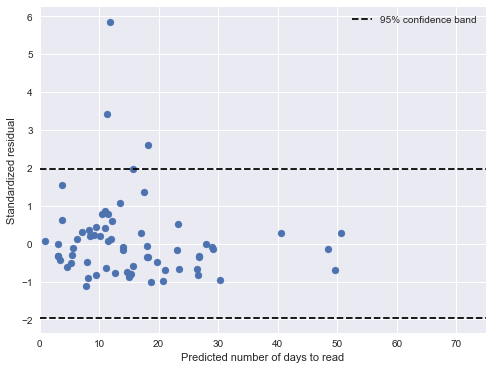

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(nb_pred_days, nb_std_resid);

ax.hlines(
    sp.stats.norm.isf([0.975, 0.025]),
    0, 75,
    linestyles='--', label="95% confidence band"
);

ax.set_xlim(0, 75);
ax.set_xlabel("Predicted number of days to read");

ax.set_ylabel("Standardized residual");

ax.legend(loc=1);

If the model is correct, approximately 95% of the residuals should lie between the dotted horizontal lines, and indeed most residuals are in this band.

We also plot the standardized residuals against the number of pages in the book, and notice no troubling patterns.

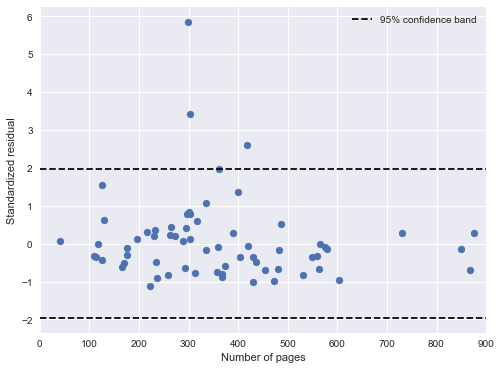

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(df['pages'], nb_std_resid);

ax.hlines(
    sp.stats.norm.isf([0.975, 0.025]),
    0, 900,
    linestyles='--', label="95% confidence band"
);

ax.set_xlim(0, 900);
ax.set_xlabel("Number of pages");

ax.set_ylabel("Standardized residual");

ax.legend(loc=1);

We now examine this model's predictions directly by sampling from the posterior predictive distribution.

In [37]:
PP_PAGES = np.linspace(1, 1000, 300, dtype=np.int64)

pages_.set_value(PP_PAGES)

with nb_model:
    pp_nb_trace = pm.sample_ppc(nb_trace, samples=5000)

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 2015.00it/s]


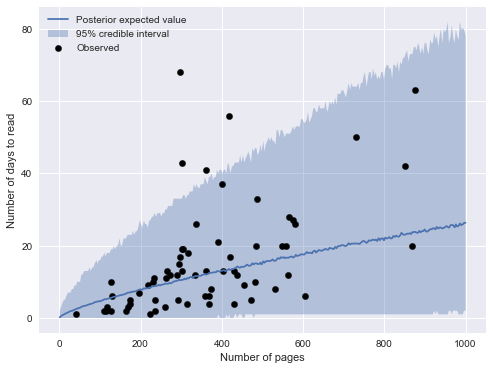

In [39]:
fig, ax = plt.subplots(figsize=(8, 6))

ALPHA = 0.05

low, high = np.percentile(
    pp_nb_trace['days_obs'],
    [100 * ALPHA / 2, 100 * (1 - ALPHA / 2)],
    axis=0
)

ax.fill_between(
    PP_PAGES, low, high,
    alpha=0.35,
    label=f"{1 - ALPHA:.0%} credible interval"
);
ax.plot(
    PP_PAGES, pp_nb_trace['days_obs'].mean(axis=0),
    label="Posterior expected value"
);

df.plot(
    'pages', 'days',
    s=40, c='k',
    kind='scatter',
    label="Observed",
    ax=ax
);

ax.set_xlabel("Number of pages");
ax.set_ylabel("Number of days to read");

ax.legend(loc=2);

We see that most of the obserations fall within the 95% credible interval.  An important feature of negative binomial regression is that the credible intervals expand as the predictions get larger.  This feature is reflected in the fact that the predictions are less accurate for longer books.

### Book effects

One advantage to working with such a personal data set is that I can explain the factors that led to certain outliers.  Below are the four books that I read at the slowest average rate of pages per day.

In [40]:
(df.assign(pages_per_day=df['pages'] / df['days'])
   .nsmallest(4, 'pages_per_day')
   [['title', 'author', 'start_date', 'pages_per_day']])

,title,author,start_date,pages_per_day
41,The Handmaid's Tale,Margaret Atwood,2016-10-16,4.382353
48,The Shadow of the Torturer,Gene Wolf,2017-03-11,7.046512
24,The Song of the Lark,Willa Cather,2016-02-14,7.446429
61,The History of Statistics: The Measurement of ...,Stephen M. Stigler,2017-10-27,8.804878


Several of these books make sense; I found [_The Shadow of the Torturer_](https://en.wikipedia.org/wiki/The_Shadow_of_the_Torturer) to be an unpleasant slog and [_The History of Statistics_](http://www.hup.harvard.edu/catalog.php?isbn=9780674403413) was quite technical and dense.  On the other hand, [_The Handmaid's Tale_](https://en.wikipedia.org/wiki/The_Handmaid%27s_Tale) and [_The Song of the Lark_](https://en.wikipedia.org/wiki/The_Song_of_the_Lark) were both quite enjoyable, but my time reading them coincided with other notable life events.  I was reading _The Handmaid's Tale_ when certain unfortunate American political developments distracted me for several weeks in November 2016, and I was reading _The Song of the Lark_ when a family member passed away in March 2016.

We modify the negative binomial regression model to include special factors for _The Handmaid's Tale_ and _The Song of the Lark_, in order to mitigate the influence of these unusual circumstances on our parameter estimates.

We let

$$
x^{\textrm{handmaid}}_i = \begin{cases}
    1 & \textrm{if the } i\textrm{-th book is }\textit{The Handmaid's Tale} \\
    0 & \textrm{if the } i\textrm{-th book is not }\textit{The Handmaid's Tale}
\end{cases},
$$

and similarly for $x^{\textrm{lark}}_i$.  We add the terms

$$
\begin{align*}
    \beta^{\textrm{handmaid}}, \beta^{\textrm{lark}}
        & \sim N(0, 5^2) \\
    \beta^{\textrm{book}}_i
        & = \beta^{\textrm{handmaid}} \cdot x^{\textrm{handmaid}}_i + \beta^{\textrm{lark}} \cdot x^{\textrm{lark}}_i \\
    \theta_i
        & \sim \beta_0 + \beta^{\textrm{book}}_i + \beta^{\textrm{pages}} \cdot x^{\textrm{pages}}_i
\end{align*}
$$

to the model below.

In [45]:
is_lark = (df['title']
             .eq("The Song of the Lark")
             .mul(1.)
             .values)
is_lark_ = shared(is_lark)

is_handmaid = (df['title']
                 .eq("The Handmaid's Tale")
                 .mul(1.)
                 .values)
is_handmaid_ = shared(is_handmaid)
# print(is_lark)
# print(is_handmaid)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [42]:
pages_.set_value(pages)

In [43]:
with pm.Model() as book_model:
    β0 = pm.Normal('β0', 0., 5.)
    
    β_lark = pm.Normal('β_lark', 0., 5.)
    β_handmaid = pm.Normal('β_handmaid', 0., 5.)
    β_book = β_lark * is_lark_ + β_handmaid * is_handmaid_
    
    β_pages = pm.Normal('β_pages', 0., 5.)
    
    log_pages = tt.log(pages_)
    log_pages_std = (log_pages - log_pages.mean()) / log_pages.std()
    
    θ = β0 + β_book + β_pages * log_pages_std
    μ = tt.exp(θ)
    
    α = pm.Lognormal('α', 0., 5.)
    
    days_obs = pm.NegativeBinomial('days_obs', μ, α, observed=days - 1)

We now sample from the model's posterior distribution.

In [44]:
with book_model:
    book_trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Again, the BFMI, energy plots and Gelman-Rubin statistics indicate convergence.

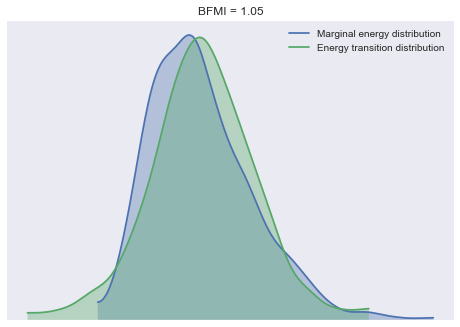

In [48]:
ax = pm.energyplot(book_trace)

bfmi = pm.bfmi(book_trace)
ax.set_title(f"BFMI = {bfmi:.2f}");

In [47]:
max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(book_trace).values())

1.0060696638434352

We see that the special factors for _The Handmaid's Tale_ and _The Song of the Lark_ were indeed notable.

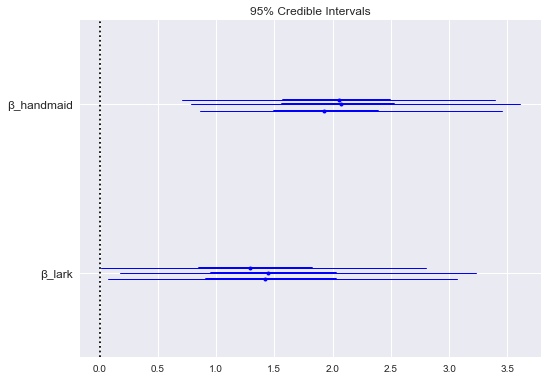

In [49]:
pm.forestplot(
    book_trace, varnames=['β_handmaid', 'β_lark'],
    chain_spacing=0.025,
    rhat=False
);

Again, we calculate the model's predictions in order to examine standardized residuals.

In [50]:
with book_model:
    book_pred_trace = pm.sample_ppc(book_trace)
    
book_pred_days = book_pred_trace['days_obs'].mean(axis=0)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 328.68it/s]


In [51]:
book_std_resid = (days - book_pred_days) / book_pred_trace['days_obs'].std(axis=0)

Both standardized residual plots show no cause for concern.

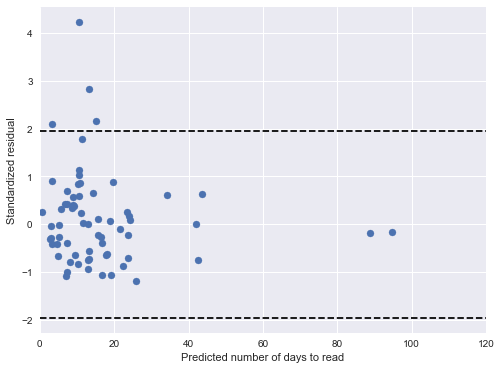

In [52]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(book_pred_days, book_std_resid);

ax.hlines(
    sp.stats.norm.isf([0.975, 0.025]),
    0, 120,
    linestyles='--', label="95% confidence band"
);

ax.set_xlim(0, 120);
ax.set_xlabel("Predicted number of days to read");

ax.set_ylabel("Standardized residual");

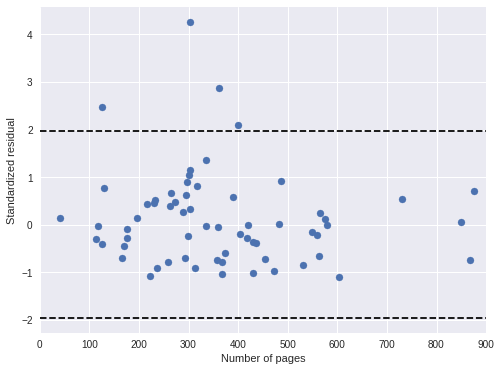

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(df['pages'], book_std_resid);

ax.hlines(
    sp.stats.norm.isf([0.975, 0.025]),
    0, 900,
    linestyles='--', label="95% confidence band"
);

ax.set_xlim(0, 900);
ax.set_xlabel("Number of pages");

ax.set_ylabel("Standardized residual");

Since we now have two models, we use [WAIC](http://www.jmlr.org/papers/volume14/watanabe13a/watanabe13a.pdf) to compare them.

In [53]:
compare_df = (pm.compare(
                    [nb_trace, book_trace],
                    [nb_model, book_model]
                )
                .rename(index={0: 'NB', 1: 'Book'}))

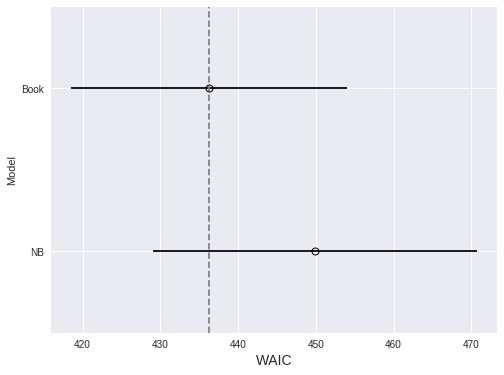

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))

pm.compareplot(
    compare_df, 
    insample_dev=False, dse=False,
    ax=ax
);

ax.set_xlabel("WAIC");
ax.set_ylabel("Model");

Since lower WAIC is better, we prefer the model with book effects, although not conclusively.

Again, we examine this model's predictions directly by sampling from the posterior predictive distribution.

In [54]:
pages_.set_value(PP_PAGES)
is_handmaid_.set_value(np.zeros_like(PP_PAGES))
is_lark_.set_value(np.zeros_like(PP_PAGES))

with book_model:
    pp_book_trace = pm.sample_ppc(book_trace, samples=5000)

  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]


ValueError: Input dimension mis-match. (input[2].shape[0] = 66, input[6].shape[0] = 300)
Apply node that caused the error: Elemwise{Composite{exp((i0 + (i1 * i2) + (i3 * i4) + (i5 * (i6 / i7))))}}[(0, 6)](InplaceDimShuffle{x}.0, InplaceDimShuffle{x}.0, <TensorType(float64, vector)>, InplaceDimShuffle{x}.0, <TensorType(float64, vector)>, InplaceDimShuffle{x}.0, Elemwise{Sub}[(0, 0)].0, Elemwise{Composite{sqrt((i0 / i1))}}[(0, 0)].0)
Toposort index: 16
Inputs types: [TensorType(float64, (True,)), TensorType(float64, (True,)), TensorType(float64, vector), TensorType(float64, (True,)), TensorType(float64, vector), TensorType(float64, (True,)), TensorType(float64, vector), TensorType(float64, (True,))]
Inputs shapes: [(1,), (1,), (66,), (1,), (66,), (1,), (300,), (1,)]
Inputs strides: [(8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,)]
Inputs values: [array([ 2.54251608]), array([ 1.43774212]), 'not shown', array([ 2.34405552]), 'not shown', array([ 0.63470566]), 'not shown', array([ 1.01360318])]
Outputs clients: [['output']]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

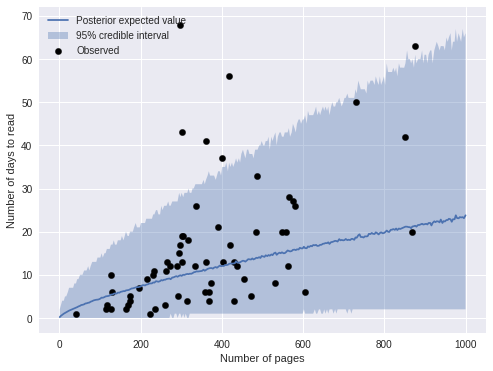

In [42]:
fig, ax = plt.subplots(figsize=(8, 6))

low, high = np.percentile(
    pp_book_trace['days_obs'],
    [100 * ALPHA / 2, 100 * (1 - ALPHA / 2)],
    axis=0
)

ax.fill_between(
    PP_PAGES, low, high,
    alpha=0.35,
    label=f"{1 - ALPHA:.0%} credible interval"
);
ax.plot(
    PP_PAGES, pp_book_trace['days_obs'].mean(axis=0),
    label="Posterior expected value"
);

df.plot(
    'pages', 'days',
    s=40, c='k',
    kind='scatter',
    label="Observed",
    ax=ax
);

ax.set_xlabel("Number of pages");
ax.set_ylabel("Number of days to read");

ax.legend(loc=2);

The predictions are visually similar to those of the previous model.  The plot below compares the two model's predictions directly.

NameError: name 'pp_book_trace' is not defined

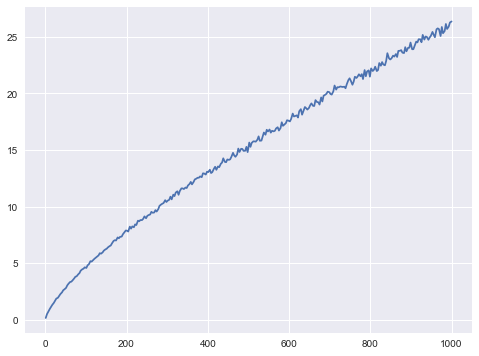

In [55]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(
    PP_PAGES, pp_nb_trace['days_obs'].mean(axis=0),
    label="Negative binomial model"
);
ax.plot(
    PP_PAGES, pp_book_trace['days_obs'].mean(axis=0),
    label="Book effect model"
);

ax.set_xlabel("Number of pages");
ax.set_ylabel("Number of days to read");

ax.legend(title="Posterior expected value", loc=2);

The predictions are quite similar, with the book effect model predicting slightly shorter durations, which makes sense as that model explicitly accounts for two books that it took me an unusually long amount of time to read.

### Timeseries model

We now turn to the goal of this post, quantifying how my reading habits have changed over time.  For computational simplicity, we operate on a time scale of weeks.  Therefore, for each book, we calculate the number of weeks from the beginning of the observation period to when I started reading it.

In [56]:
t_week = (df['start_date'] 
            .sub(df['start_date'].min())
            .dt.days
            .floordiv(7)
            .values)
t_week_ = shared(t_week)

n_week = t_week.max() + 1

We let the intercept $\beta^0$ and the (log standardized) pages coefficient $\beta^{\textrm{pages}}$ vary over time.  We give these time-varying coefficient Gaussian random walk priors,

$$
\begin{align*}
    \beta^0_t \sim N(\beta^0_{t - 1}, 10^{-2}), \\
    \beta^{\textrm{pages}}_t \sim N(\beta^{\textrm{pages}}_{t - 1}, 10^{-2}).
\end{align*}
$$

The small drift scale of $10^{-1}$ is justified by the intuition that reading habits should change gradually.

In [57]:
pages_.set_value(pages)

is_handmaid_.set_value(is_handmaid)
is_lark_.set_value(is_lark)

In [46]:
with pm.Model() as time_model:
    β0 = pm.GaussianRandomWalk(
        'β0', sd=0.1, shape=n_week
    )
    
    β_lark = pm.Normal('β_lark', 0., 5.)
    β_handmaid = pm.Normal('β_handmaid', 0., 5.)
    β_book = β_lark * is_lark_ + β_handmaid * is_handmaid_
    
    β_pages = pm.GaussianRandomWalk(
        'β_pages', sd=0.1, shape=n_week
    )
    
    log_pages = tt.log(pages_)
    log_pages_std = (log_pages - log_pages.mean()) / log_pages.std()
    
    θ = β0[t_week_] + β_book + β_pages[t_week_] * log_pages_std
    μ = tt.exp(θ)
    
    α = pm.Lognormal('α', 0., 5.)
    
    days_obs = pm.NegativeBinomial('days_obs', μ, α, observed=days - 1)

Again, we sample from the model's posterior distribution.

In [47]:
with time_model:
    time_trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [α_log__, β_pages, β_handmaid, β_lark, β0]
100%|██████████| 1000/1000 [03:26<00:00,  4.85it/s]


Again, the BFMI, energy plots, and Gelman-Rubin statistics indicate convergence.

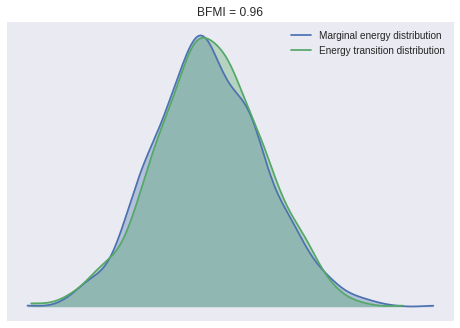

In [48]:
ax = pm.energyplot(time_trace)

bfmi = pm.bfmi(time_trace)
ax.set_title(f"BFMI = {bfmi:.2f}");

In [49]:
max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(time_trace).values())

1.0038733152191415

Once more, we examime the model's standardized residuals.

In [50]:
with time_model:
    time_pred_trace = pm.sample_ppc(time_trace)
    
time_pred_days = time_pred_trace['days_obs'].mean(axis=0)

100%|██████████| 500/500 [00:00<00:00, 913.23it/s]


In [51]:
time_std_resid = (days - time_pred_days) / time_pred_trace['days_obs'].std(axis=0)

In general, the standardized residuals are now smaller and fewer are outside of the 95% confidence band.

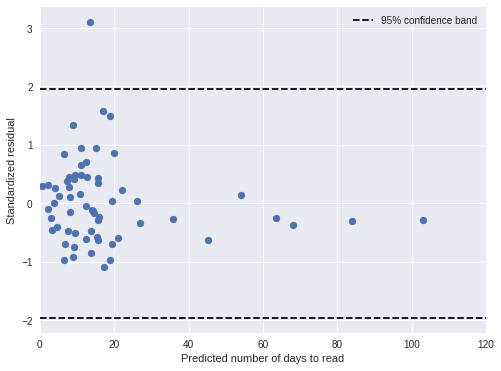

In [52]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(time_pred_days, time_std_resid);

ax.hlines(
    sp.stats.norm.isf([0.975, 0.025]),
    0, 120,
    linestyles='--', label="95% confidence band"
);

ax.set_xlim(0, 120);
ax.set_xlabel("Predicted number of days to read");

ax.set_ylabel("Standardized residual");

ax.legend(loc=1);

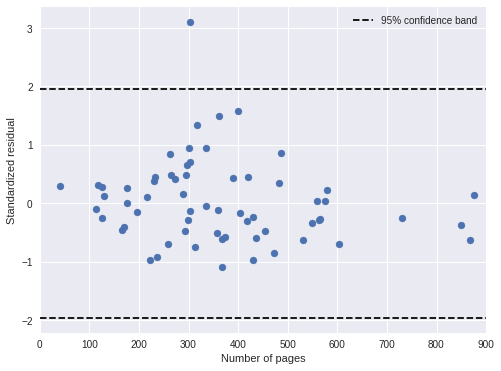

In [53]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(df['pages'], time_std_resid);

ax.hlines(
    sp.stats.norm.isf([0.975, 0.025]),
    0, 900,
    linestyles='--', label="95% confidence band"
);

ax.set_xlim(0, 900);
ax.set_xlabel("Number of pages");
ax.set_ylabel("Standardized residual");

ax.legend(loc=1);

Again, we use WAIC to compare the three models.

In [54]:
compare_df = (pm.compare(
                    [nb_trace, book_trace, time_trace],
                    [nb_model, book_model, time_model]
                )
                .rename(index={0: 'NB', 1: 'Book', 2: 'Time'}))

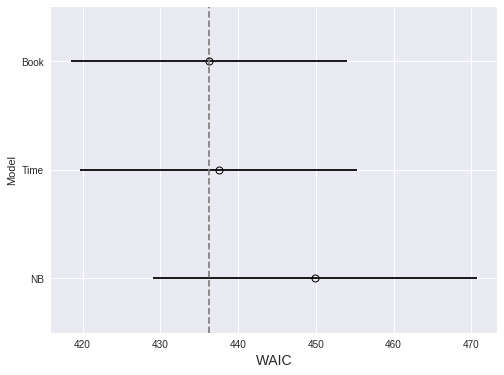

In [55]:
fig, ax = plt.subplots(figsize=(8, 6))

pm.compareplot(
    compare_df, 
    insample_dev=False, dse=False,
    ax=ax
);

ax.set_xlabel("WAIC");
ax.set_ylabel("Model");

The timeseries model performs marginally worse than the previous model.  We proceed since only the timeseries model answers our original question.

We now use the timeseries model to show how the amount of time it takes me to read a book has changed over time, conditioned on the length of the book.

In [56]:
t_grid = np.linspace(
    mdates.date2num(df['start_date'].min()),
    mdates.date2num(df['start_date'].max()),
    n_week
)

In [57]:
PP_TIME_PAGES = np.array([100, 200, 300, 400, 500])

pp_df = (pd.DataFrame(
                list(product(
                    np.arange(n_week),
                    PP_TIME_PAGES
                )),
                columns=['t_week', 'pages']
           )
           .assign(
               is_handmaid=0,
               is_lark=0
           ))

In [58]:
is_handmaid_.set_value(pp_df['is_handmaid'].values)
is_lark_.set_value(pp_df['is_lark'].values)

t_week_.set_value(pp_df['t_week'].values)
pages_.set_value(pp_df['pages'].values)

In [59]:
with time_model:
    pp_time_trace = pm.sample_ppc(time_trace, samples=10000)

100%|██████████| 10000/10000 [00:12<00:00, 791.11it/s]


In [60]:
pp_df['pp_days'] = pp_time_trace['days_obs'].mean(axis=0)
pp_df['t_plot'] = np.repeat(t_grid, 5)

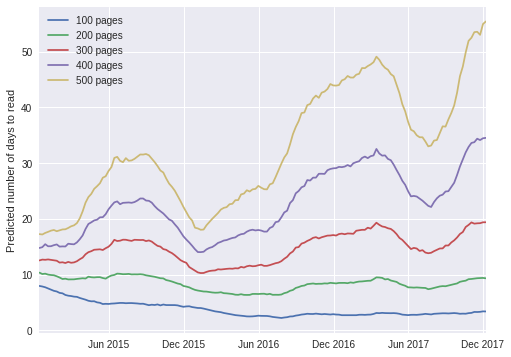

In [61]:
fig, ax = plt.subplots(figsize=(8, 6))

for grp_pages, grp_df in pp_df.groupby('pages'):
    grp_df.plot(
        't_plot', 'pp_days',
        label=f"{grp_pages} pages",
        ax=ax
    );
    
ax.set_xlim(t_grid.min(), t_grid.max());
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'));
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6));
ax.xaxis.label.set_visible(False);

ax.set_ylabel("Predicted number of days to read");

The plot above exhibits a fascinating pattern; according to the timeseries model, I now read shorter books (fewer than approximately 300 pages) slightly faster than I did in 2015, but it takes me twice as long as before to read longer books.  The trend for longer books is easier to explain; in the last 12-18 months, I have been doing much more public speaking and blogging than before, which naturally takes time away from reading.  The trend for shorter books is a bit harder to explain, but upon some thought, I tend to read more purposefully as I approach the end of a book, looking forward to starting a new one.  This effect occurs much earlier in shorter books than in longer ones, so it is a plausible explanation for the trend in shorter books.

This post is available as a Jupyter notebook [here](http://nbviewer.jupyter.org/gist/AustinRochford/722d4a98ba45f577b7e415e2b73cda0d).